In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
import deepchem as dc
from deepchem.molnet import load_qm7
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.Chem import Draw, rdDepictor
from IPython.display import SVG

from __future__ import print_function
from __future__ import division
from __future__ import unicode_literals

%matplotlib inline

### Load data set 


In [28]:
# dataset_file = "../deepchem/datasets/gdb1k.sdf"
# featurizer = dc.feat.CoulombMatrix(max_atoms=23, remove_hydrogens=False, randomize=True, n_samples=1)

# loader = dc.data.SDFLoader(
#       tasks=["atomization_energy"], smiles_field="smiles",
#       featurizer=featurizer,
#       mol_field="mol")

# dataset = loader.featurize(dataset_file)

tasks, datasets, transformers = load_qm7(featurizer='CoulombMatrix', split='stratified', 
                                                      move_mean=True, reload=True)


train_dataset, valid_dataset, test_dataset = datasets

About to featurize qm7 dataset.
Loading raw samples now.
shard_size: 8192
Reading structures from /var/folders/lt/4hfpdkdn0mzf1tl30rhyncn0g8k1ts/T/gdb7.sdf.
Currently featurizing feature_type: CoulombMatrixEig
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
TIMING: featurizing shard 0 took 5.351 s
TIMING: dataset construction took 6.852 s
Loading dataset from disk.
TIMING: dataset construction took 0.049 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.
TIMING: dataset construction took 0.049 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.


Hansen et al (2013) state that normalisation scaling of inputs is detrimental to model performance as the input dimensions are related. 
In this notebook, we will compare the performance of scaled and non-scaled inputs. 



In [33]:
print(train_dataset.get_shape())
print(valid_dataset.get_shape())
print(test_dataset.get_shape())

((5728, 23), (5728, 1), (5728, 1), (5728,))
((716, 23), (716, 1), (716, 1), (716,))
((716, 23), (716, 1), (716, 1), (716,))


train ((5728, 23), (5728, 1), (5728, 1), (5728,))


RDKit ERROR: [08:22:32] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [08:22:32] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [08:22:32] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [08:22:32] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [08:22:32] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [08:22:32] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [08:22:32] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [08:22:32] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [08:22:32] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [08:22:32] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [08:22:32] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [08:22:32] Explicit valence for atom # 4 

RDKit ERROR: [08:22:33] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [08:22:33] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [08:22:33] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [08:22:33] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [08:22:33] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [08:22:33] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [08:22:33] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [08:22:33] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [08:22:33] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [08:22:33] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [08:22:33] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [08:22:33] Explicit valence for atom # 1 

valid ((716, 23), (716, 1), (716, 1), (716,))
test ((716, 23), (716, 1), (716, 1), (716,))


RDKit ERROR: [08:22:33] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [08:22:33] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [08:22:33] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [08:22:33] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [08:22:33] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [08:22:33] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [08:22:33] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [08:22:33] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [08:22:33] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [08:22:33] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [08:22:33] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [08:22:33] Explicit valence for atom # 6 

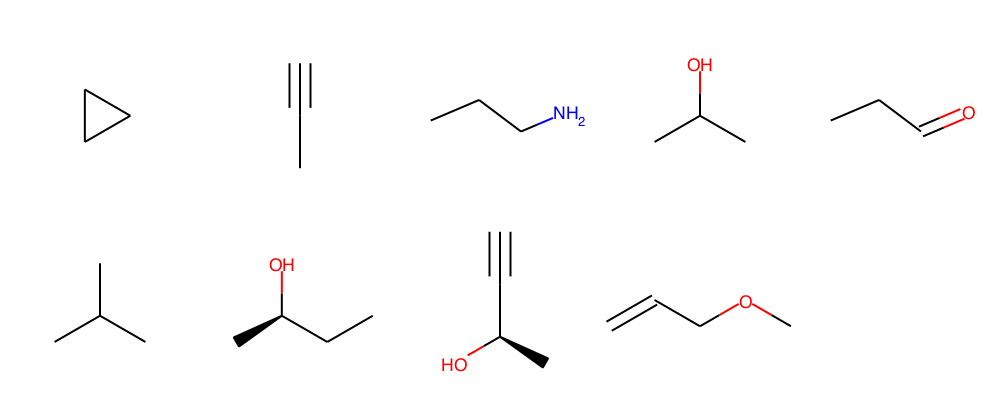

In [30]:
## Dataset analysis

for data, name in zip([train_dataset, valid_dataset, test_dataset],['train', 'valid', 'test']):
    print(name, data.get_shape())
   # print(name, data.get_statistics())
    mol_list = [Chem.MolFromSmiles(id_) for id_ in data.ids]
    #SVG(moltosvg(mol_list[0]))

Chem.Draw.MolsToGridImage(mol_list[:10], molsPerRow=5)#legends=[mol.GetProp('_Name') for mol in mol_list[:10]])

# mol_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
# Chem.Draw.MolsToGridImage(mol_list,legends=[mol.GetProp('_Name') for mol in mol_list])

## Keras Neural Networks

In [80]:
## Functions

def plot_history(history, title):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    #fig, ax = plt.subplots(1,2, figsize=(12,6))
    plt.figure(figsize=(8,6))
   # plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Loss')
    plt.title(title)
    plt.legend()
    #plt.ylim([0,5])
    #ax[0].legend()
    plt.show()

Model parameters and weights inspired by Hansen et al (2015) Journal of Physical Chemistry Letters

Initial weights W0 and learning rates γ are chosen as W0 ∼ N(0, 1/√m) and γ = γ0/√m where m is the number of input units and γ0 is the global learning rate of the network set to γ0 = 0.01. 

In [85]:
## Keras implementation 
from tensorflow import keras

init_layer1 = keras.initializers.RandomNormal(mean=0, stddev=(1/np.sqrt(400)))
init_layer2 = keras.initializers.RandomNormal(mean=0, stddev=(1/np.sqrt(100)))
#lr = 0.01/np.sqrt(400)
lr = 0.001
# Network

model = tf.keras.Sequential([
keras.layers.Dense(400, input_shape=(23,), kernel_initializer=init_layer1, activation='sigmoid'),
keras.layers.Dense(100, activation='sigmoid', kernel_initializer=init_layer2),
#keras.layers.Dense(100, activation='sigmoid'),
keras.layers.Dense(1)])

# Optimizer
sgd = keras.optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)

# Configure a model for mean-squared error regression.
model.compile(optimizer=sgd,
              loss='mae',       # mean squared error
              metrics=['mae', 'mse'])  # mean absolute error

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

# Save model weights checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint('sgd_model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')

# Train on dataset

X_train = train_dataset.X
y_train = train_dataset.y


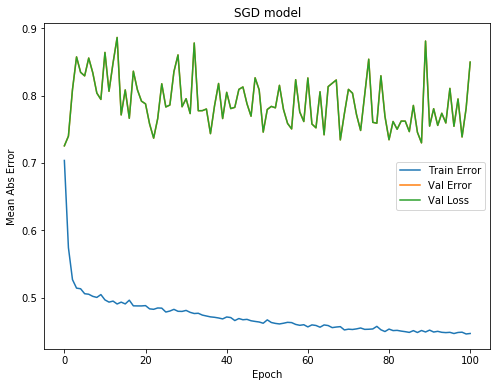

In [86]:
history = model.fit(X_train, y_train, validation_split = 0.1, epochs=500, 
                    callbacks=[early_stop], batch_size=25, verbose=0)

plot_history(history, "SGD model")

shape X_test:  (716, 23)
shape y_test:  (716, 1)
716/716 [==============================] - 0s 39us/sample - loss: 0.6044 - mean_absolute_error: 0.6044 - mean_squared_error: 0.6135


/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


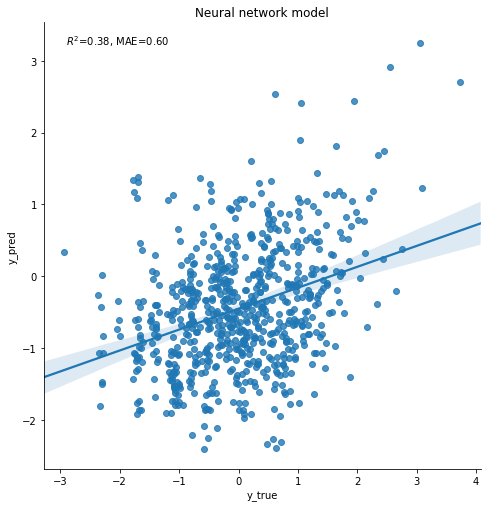

In [88]:
# Test
from sklearn import metrics 

X_valid = valid_dataset.X
y_valid = valid_dataset.y

print("shape X_test: ", X_valid.shape)
print("shape y_test: ", y_valid.shape)

predictions = model.predict(X_valid)
scores = model.evaluate(X_valid, y_valid)
errors = {}

errors['mean_absolute_error'] = metrics.mean_absolute_error(y_valid, predictions)
errors['mean_squared_error'] = metrics.mean_squared_error(y_valid, predictions)


# fig, ax = plt.subplots(1, 1, figsize=(8,6))
# ax.bar(['train', 'test'], [train_scores['mean_absolute_error'], test_scores['mean_absolute_error']])
# #ax[1].bar(['mae', 'pearsons_r2'], test_scores)
# plt.title("Kernel ridge regression")
# plt.ylabel("mean absolute error")
# plt.show()

results = pd.DataFrame(predictions, columns = ['y_pred'])
results['y_true'] = y_test
sns.pairplot(results, x_vars='y_true', y_vars='y_pred', height=7, aspect=1, kind='reg')
plt.title("Neural network model")
plt.annotate('$R^2$=%.2f, MAE=%.2f' % (metrics.r2_score(y_valid, predictions), 
                                       metrics.mean_absolute_error(y_valid, predictions)), 
                                    xy=(0.05, 0.95), xycoords='axes fraction')
plt.show()


In [89]:
scores

[0.6043836737478245, 0.60438365, 0.61349964]

## Kernel Ridge Regression 

About to initialize singletask to multitask model
Initializing directory for task u0_atom
About to create task-specific datasets
Splitting multitask dataset into singletask datasets
TIMING: dataset construction took 0.007 s
Loading dataset from disk.
Processing shard 0
	Task u0_atom
Dataset for task u0_atom has shape ((5728, 23), (5728, 1), (5728, 1), (5728,))
Fitting model for task u0_atom
computed_metrics: [44.8348772443017]
Train scores [kcal/mol]
{'mean_absolute_error': 44.8348772443017}
computed_metrics: [63.57846718781165]
Validation scores [kcal/mol]
{'mean_absolute_error': 63.57846718781165}


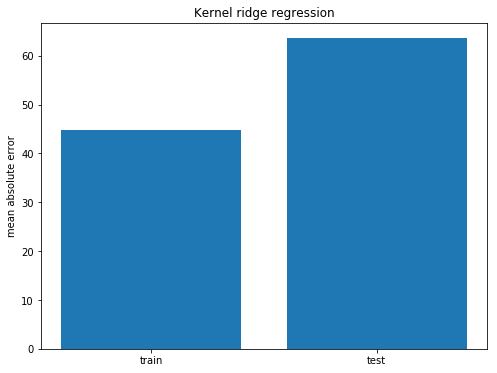

In [43]:
from deepchem.models.tensorgraph.optimizers import ExponentialDecay
from sklearn.kernel_ridge import KernelRidge
tf.set_random_seed(123)

## Kernel ridge regression

def krr_model_builder(model_dir):
    sklearn_model = KernelRidge(kernel='laplacian', alpha=0.0001, gamma=0.0001)
    return dc.models.SklearnModel(sklearn_model, model_dir)

regression_metric = dc.metrics.Metric(
    dc.metrics.mean_absolute_error, mode="regression")

krr = dc.models.SingletaskToMultitask(tasks, krr_model_builder)

# Fit trained model
krr.fit(train_dataset)
#model.save()

train_evaluator = dc.utils.evaluate.Evaluator(krr, train_dataset, transformers)
train_scores = train_evaluator.compute_model_performance([regression_metric])

print("Train scores [kcal/mol]")
print(train_scores)

test_evaluator = dc.utils.evaluate.Evaluator(krr, test_dataset, transformers)
test_scores = test_evaluator.compute_model_performance([regression_metric])

print("Validation scores [kcal/mol]")
print(test_scores)

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.bar(['train', 'test'], [train_scores['mean_absolute_error'], test_scores['mean_absolute_error']])
#ax[1].bar(['mae', 'pearsons_r2'], test_scores)
plt.title("Kernel ridge regression")
plt.ylabel("mean absolute error")
plt.show()

## DTNN

In [44]:
# Load QM7 dataset
# tasks, datasets, transformers = dc.molnet.load_qm7_from_mat(move_mean=False)
# train_dataset, valid_dataset, test_dataset = datasets

# Fit models
metric = [
    dc.metrics.Metric(dc.metrics.mean_absolute_error, mode="regression"),
    dc.metrics.Metric(dc.metrics.pearson_r2_score, mode="regression")
]

# Batch size of models
batch_size = 50
n_embedding = 30
n_distance = 51
distance_min = -1.
distance_max = 9.2
n_hidden = 15
rate = 0.001

dtnn_model = dc.models.DTNNModel(
    len(tasks),
    n_embedding=n_embedding,
    n_hidden=n_hidden,
    n_distance=n_distance,
    distance_min=distance_min,
    distance_max=distance_max,
    output_activation=False,
    batch_size=batch_size,
    learning_rate=rate,
    use_queue=False,
    mode="regression")

# Fit trained model
model.fit(train_dataset, nb_epoch=50)

train_scores = model.evaluate(train_dataset, metric, transformers)
valid_scores = model.evaluate(valid_dataset, metric, transformers)

IndexError: too many indices for array

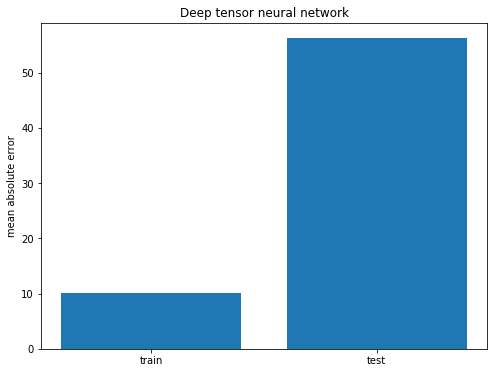

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.bar(['train', 'test'], [train_scores['mean_absolute_error'], test_scores['mean_absolute_error']])
#ax[1].bar(['mae', 'pearsons_r2'], test_scores)
plt.title("Deep tensor neural network")
plt.ylabel("mean absolute error")
plt.show()

## Single task NN 

In [ ]:
from deepchem.molnet import load_qm7_from_mat
from deepchem.models.tensorgraph.optimizers import ExponentialDecay

print(tf.__version__)

qm7_tasks, datasets, transformers = load_qm7_from_mat(
    split='stratified', move_mean=True, reload=False)


qm_train, qm_valid, qm_test = datasets

fit_transformers = [dc.trans.CoulombFitTransformer(qm_train)]

rate = 0.001
dc_model = dc.models.MultitaskFitTransformRegressor(
    n_tasks=1,
    n_features=[23, 23],
    learning_rate=rate,
    momentum=.8,
    batch_size=25,
    weight_init_stddevs=[1 / np.sqrt(400), 1 / np.sqrt(100), 1 / np.sqrt(100)],
    bias_init_consts=[0., 0., 0.],
    layer_sizes=[400, 100, 100],
    dropouts=[0.01, 0.01, 0.01],
    fit_transformers=fit_transformers,
    n_evals=10,
    seed=123)




In [ ]:
# Fit trained model
dc_model.fit(qm_train, nb_epoch=50)

train_scores = dc_model.evaluate(qm_train, metric, transformers)
valid_scores = dc_model.evaluate(qm_valid, metric, transformers)